In [1]:
!pip install --no-cache-dir transformers huggingface_hub==0.27.0 datasets accelerate

INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 116.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 216.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 185.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 224.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 157.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 240.7 MB/s eta 0:00:00
INFO: pip is still looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 211.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0

In [2]:
# Standard library
import json
from time import sleep
from collections import Counter

# Third-party
import numpy as np
import requests
import matplotlib.pyplot as plt
#import torch
#from torch import nn
from sklearn.metrics import (
    classification_report,
    f1_score,
    hamming_loss,
    accuracy_score
)

# Datasets
from datasets import load_dataset, Dataset

In [3]:
ds = load_dataset("lex_glue", "eurlex")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/167M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/24.3M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/55000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [4]:
print(ds["train"][0])

{'text': 'COUNCIL DECISION\nof 7 June 2005\nabrogating Decision 2005/136/EC on the existence of an excessive deficit in the Netherlands\n(2005/729/EC)\nTHE COUNCIL OF THE EUROPEAN UNION,\nHaving regard to the Treaty establishing the European Community, and in particular Article 104(12) thereof,\nHaving regard to the recommendation from the Commission,\nWhereas:\n(1)\nBy Decision 2005/136/EC (1) following a recommendation from the Commission in accordance with Article 104(6) of the Treaty, the Council decided that an excessive deficit existed in the Netherlands.\n(2)\nIn accordance with Article 104(7) of the Treaty, the Council made a Recommendation on 2 June 2004 addressed to the Netherlands with a view to bringing the excessive deficit situation to an end. This Recommendation, in conjunction with Article 3(4) of Council Regulation (EC) No 1467/97 of 7 July 1997 on speeding up and clarifying the implementation of the excessive deficit procedure (2), established a deadline of 2005 at th

In [5]:
print(ds["train"])

Dataset({
    features: ['text', 'labels'],
    num_rows: 55000
})


In [6]:
label_name = ds["train"].features["labels"].feature.names
label_name

['100163',
 '100168',
 '100169',
 '100170',
 '100171',
 '100172',
 '100173',
 '100174',
 '100175',
 '100176',
 '100177',
 '100179',
 '100180',
 '100183',
 '100184',
 '100185',
 '100186',
 '100187',
 '100189',
 '100190',
 '100191',
 '100192',
 '100193',
 '100194',
 '100195',
 '100196',
 '100197',
 '100198',
 '100199',
 '100200',
 '100201',
 '100202',
 '100204',
 '100205',
 '100206',
 '100207',
 '100212',
 '100214',
 '100215',
 '100220',
 '100221',
 '100222',
 '100223',
 '100224',
 '100226',
 '100227',
 '100229',
 '100230',
 '100231',
 '100232',
 '100233',
 '100234',
 '100235',
 '100237',
 '100238',
 '100239',
 '100240',
 '100241',
 '100242',
 '100243',
 '100244',
 '100245',
 '100246',
 '100247',
 '100248',
 '100249',
 '100250',
 '100252',
 '100253',
 '100254',
 '100255',
 '100256',
 '100257',
 '100258',
 '100259',
 '100260',
 '100261',
 '100262',
 '100263',
 '100264',
 '100265',
 '100266',
 '100268',
 '100269',
 '100270',
 '100271',
 '100272',
 '100273',
 '100274',
 '100275',
 '100276',

In [7]:
label2name = ds["train"].features["labels"].feature.names

c=0
for i, name in enumerate(label2name):
    if not c==5:
        print(i, name)
    else:
        break
    c+=1

0 100163
1 100168
2 100169
3 100170
4 100171


In [8]:
def get_eurovoc_label(concept_id):
    """Fetch label from EuroVoc SPARQL endpoint"""
    sparql_endpoint = "http://publications.europa.eu/webapi/rdf/sparql"
    
    query = f"""
    PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
    SELECT ?label
    WHERE {{
      <http://eurovoc.europa.eu/{concept_id}> skos:prefLabel ?label .
      FILTER(lang(?label) = 'en')
    }}
    """
    
    try:
        response = requests.get(
            sparql_endpoint,
            params={'query': query, 'format': 'json'},
            timeout=10
        )
        if response.status_code == 200:
            data = response.json()
            if data['results']['bindings']:
                return data['results']['bindings'][0]['label']['value']
    except Exception as e:
        print(f"Error for {concept_id}: {e}")
    
    return concept_id

# Build mapping with rate limiting
label2description = {}
for i, concept_id in enumerate(label2name):
    label2description[concept_id] = get_eurovoc_label(concept_id)
    print(f"{concept_id}: {label2description[concept_id]}")
    if i % 10 == 0:  # Add delay every 10 requests
        sleep(1)

100163: 0406 political framework
100168: 0431 politics and public safety
100169: 0436 executive power and public service
100170: 0806 international affairs
100171: 0811 cooperation policy
100172: 0816 international security
100173: 0821 defence
100174: 1006 EU institutions and European civil service
100175: 1011 European Union law
100176: 1016 European construction
100177: 1021 EU finance
100179: 1211 civil law
100180: 1216 criminal law
100183: 1231 international law
100184: 1236 rights and freedoms
100185: 1606 economic policy
100186: 1611 economic conditions
100187: 1616 regions and regional policy
100189: 1626 national accounts
100190: 1631 economic analysis
100191: 2006 trade policy
100192: 2011 tariff policy
100193: 2016 trade
100194: 2021 international trade
100195: 2026 consumption
100196: 2031 marketing
100197: 2036 distributive trades
100198: 2406 monetary relations
100199: 2411 monetary economics
100200: 2416 financial institutions and credit
100201: 2421 free movement of cap

In [9]:
high_level_categories = {
    "Politics & Government": {
        "100163", "100168", "100169", "100174", "100175", "100176", "100177"
    },
    
    "International Affairs & Defense": {
        "100170", "100171", "100172", "100173", "100183", "100285"
    },
    
    "Law & Justice": {
        "100179", "100180", "100184"
    },
    
    "Economics & Finance": {
        "100185", "100186", "100189", "100190", "100198", "100199", "100200", 
        "100201", "100202", "100204", "100205", "100206", "100207"
    },
    
    "Trade & Business": {
        "100191", "100192", "100193", "100194", "100195", "100196", "100197",
        "100226", "100227", "100229", "100230", "100231"
    },
    
    "Employment & Labor": {
        "100232", "100233", "100234", "100235"
    },
    
    "Social Affairs & Health": {
        "100212", "100214", "100215"
    },
    
    "Technology & Science": {
        "100220", "100221", "100222", "100223", "100224", "100261", "100262"
    },
    
    "Transportation": {
        "100237", "100238", "100239", "100240", "100241"
    },
    
    "Environment": {
        "100242", "100243", "100244"
    },
    
    "Agriculture & Food": {
        "100245", "100246", "100247", "100248", "100249", "100250", "100252",
        "100253", "100254", "100255", "100256", "100257", "100258", "100259"
    },
    
    "Energy & Resources": {
        "100263", "100264", "100265", "100266"
    },
    
    "Industry & Manufacturing": {
        "100260", "100268", "100269", "100270", "100271", "100272", "100273",
        "100274", "100275", "100276"
    },
    
    "Geography & Regional": {
        "100187", "100277", "100278", "100279", "100280", "100281", "100282",
        "100283", "100284"
    },
}

# Verify all classes are mapped
all_mapped = set()
for classes in high_level_categories.values():
    all_mapped.update(classes)

all_labels = set(label2name)
unmapped = all_labels - all_mapped

print(f"Total labels: {len(all_labels)}")
print(f"Mapped labels: {len(all_mapped)}")
print(f"Unmapped labels: {unmapped if unmapped else 'None'}")

# Print the mapping
print("\n=== High-Level Category Mapping ===")
for category, classes in high_level_categories.items():
    print(f"\n{category}: {len(classes)} classes")
    for class_id in sorted(classes):
        print(f"  - {class_id}: {label2description.get(class_id, 'Unknown')}")

Total labels: 100
Mapped labels: 100
Unmapped labels: None

=== High-Level Category Mapping ===

Politics & Government: 7 classes
  - 100163: 0406 political framework
  - 100168: 0431 politics and public safety
  - 100169: 0436 executive power and public service
  - 100174: 1006 EU institutions and European civil service
  - 100175: 1011 European Union law
  - 100176: 1016 European construction
  - 100177: 1021 EU finance

International Affairs & Defense: 6 classes
  - 100170: 0806 international affairs
  - 100171: 0811 cooperation policy
  - 100172: 0816 international security
  - 100173: 0821 defence
  - 100183: 1231 international law
  - 100285: 7606 United Nations

Law & Justice: 3 classes
  - 100179: 1211 civil law
  - 100180: 1216 criminal law
  - 100184: 1236 rights and freedoms

Economics & Finance: 13 classes
  - 100185: 1606 economic policy
  - 100186: 1611 economic conditions
  - 100189: 1626 national accounts
  - 100190: 1631 economic analysis
  - 100198: 2406 monetary rela

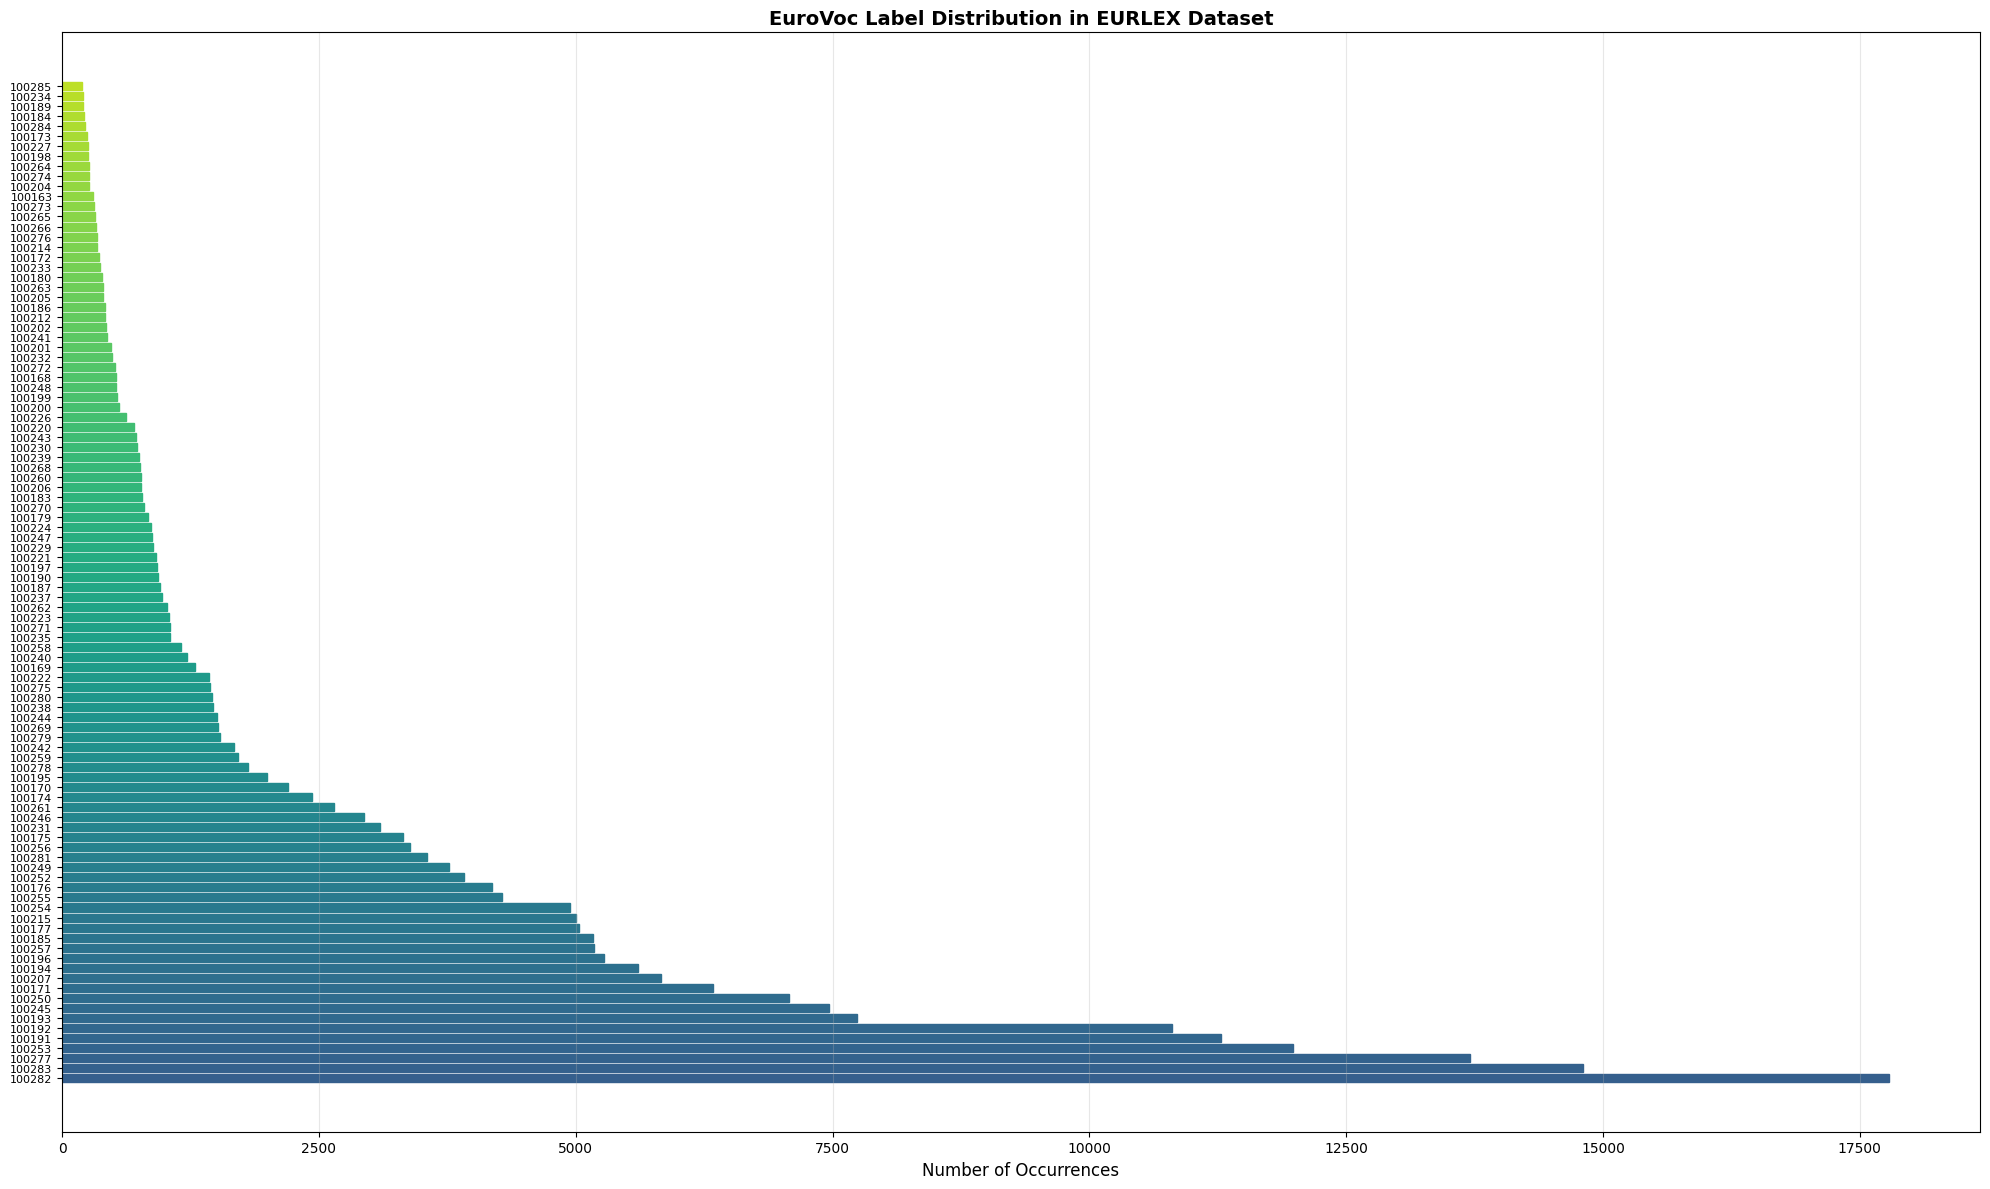


=== Dataset Statistics ===
Total examples: 55000
Total labels: 100
Total label occurrences: 243349
Average labels per document: 4.42

Top 10 most frequent labels:
  100282: 17781 (32.3%)
  100283: 14803 (26.9%)
  100277: 13702 (24.9%)
  100253: 11982 (21.8%)
  100191: 11277 (20.5%)
  100192: 10804 (19.6%)
  100193: 7739 (14.1%)
  100245: 7470 (13.6%)
  100250: 7072 (12.9%)
  100171: 6335 (11.5%)


In [10]:
#---------------------------labels occurence in the dataset------------------------------------------
# Count label occurrences (handling multi-label)
label_counts = Counter()

for example in ds["train"]:
    for label in example["labels"]:
        label_counts[label] += 1

# Get label names
label2name = ds["train"].features["labels"].feature.names

# Prepare data for plotting
labels = []
counts = []
for label_id, count in label_counts.most_common():
    label_name = label2name[label_id]
    labels.append(f"{label_name}")
    counts.append(count)

# Create the plot
plt.figure(figsize=(20, 12))
bars = plt.barh(range(len(labels)), counts)

# Color bars by frequency (darker = more frequent)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(labels)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.yticks(range(len(labels)), labels, fontsize=8)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.title('EuroVoc Label Distribution in EURLEX Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)
plt.show()

# Print statistics
print(f"\n=== Dataset Statistics ===")
print(f"Total examples: {len(ds['train'])}")
print(f"Total labels: {len(label_counts)}")
print(f"Total label occurrences: {sum(label_counts.values())}")
print(f"Average labels per document: {sum(label_counts.values()) / len(ds['train']):.2f}")
print(f"\nTop 10 most frequent labels:")
for label_id, count in label_counts.most_common(10):
    label_name = label2name[label_id]
    print(f"  {label_name}: {count} ({count/len(ds['train'])*100:.1f}%)")

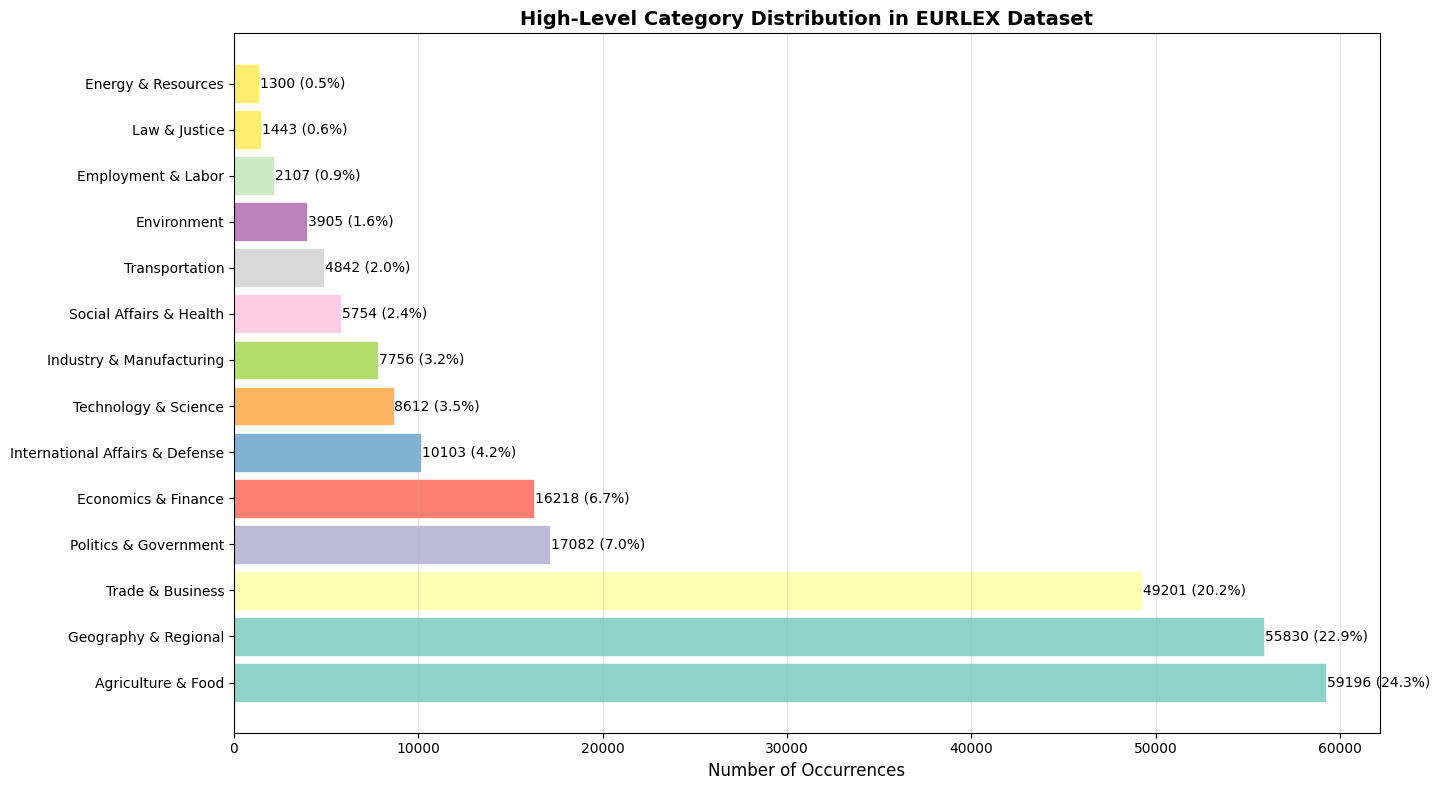

In [11]:
#------------------------------------------------------high level labels occurence in the dataset----------------------
# Create reverse mapping: label_id -> high_level_category
label_to_category = {}
for category, label_set in high_level_categories.items():
    for label_id in label_set:
        label_to_category[label_id] = category

# Count high-level category occurrences
category_counts = Counter()
for example in ds["train"]:
    for label_idx in example["labels"]:
        label_id = label2name[label_idx]
        category = label_to_category.get(label_id, "Other")
        category_counts[category] += 1

# Calculate total for percentages
total_count = sum(category_counts.values())

# Plot high-level categories
categories = [cat for cat, _ in category_counts.most_common()]
counts = [count for _, count in category_counts.most_common()]

plt.figure(figsize=(14, 8))
bars = plt.barh(categories, counts)

# Color bars
colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.xlabel('Number of Occurrences', fontsize=12)
plt.title('High-Level Category Distribution in EURLEX Dataset', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.grid(axis='x', alpha=0.3)

# Add count labels and percentages on bars
for i, (category, count) in enumerate(zip(categories, counts)):
    percentage = (count / total_count) * 100
    label = f'{count} ({percentage:.1f}%)'
    plt.text(count + 100, i, label, va='center', fontsize=10)

plt.show()

In [12]:
#------------------------------------------------------Create mappings----------------------
category_names = list(high_level_categories.keys())
category_to_id = {cat: idx for idx, cat in enumerate(category_names)}
id_to_category = {idx: cat for cat, idx in category_to_id.items()}

label_to_category_id = {}
for category, label_set in high_level_categories.items():
    for label_id in label_set:
        label_to_category_id[label_id] = category_to_id[category]

print(f"\nHigh-level categories: {len(category_names)}")
for cat in category_names:
    print(f"  - {cat}")


High-level categories: 14
  - Politics & Government
  - International Affairs & Defense
  - Law & Justice
  - Economics & Finance
  - Trade & Business
  - Employment & Labor
  - Social Affairs & Health
  - Technology & Science
  - Transportation
  - Environment
  - Agriculture & Food
  - Energy & Resources
  - Industry & Manufacturing
  - Geography & Regional


In [13]:
#------------------------------------------------------convert labels to multi-hot vector----------------------
def transform_to_multilabel(example):
    """Convert fine-grained labels into a multi-hot vector of high-level categories"""
    vector = np.zeros(len(category_names), dtype=int)
    for label_idx in example["labels"]:
        label_id = label2name[label_idx]
        if label_id in label_to_category_id:
            vector[label_to_category_id[label_id]] = 1
    return {"text": example["text"], "labels": vector.tolist()}

train_data = [transform_to_multilabel(ex) for ex in ds["train"]]
val_data = [transform_to_multilabel(ex) for ex in ds["validation"]]
test_data = [transform_to_multilabel(ex) for ex in ds["test"]]

In [14]:
print(f"\nDataset sizes after transformation:")
print(f"  Train: {len(train_data)}")
print(f"  Val: {len(val_data)}")
print(f"  Test: {len(test_data)}")


Dataset sizes after transformation:
  Train: 55000
  Val: 5000
  Test: 5000


In [15]:
#------------------------------------------------------Remove unmapped (-1 labels)----------------------
train_data = [ex for ex in train_data if ex["labels"] != -1]
val_data = [ex for ex in val_data if ex["labels"] != -1]
test_data = [ex for ex in test_data if ex["labels"] != -1]

print(f"\nDataset sizes after transformation:")
print(f"  Train: {len(train_data)}")
print(f"  Val: {len(val_data)}")
print(f"  Test: {len(test_data)}")


Dataset sizes after transformation:
  Train: 55000
  Val: 5000
  Test: 5000


In [16]:
# Count occurrences of each category across all documents
category_document_counts = Counter()

for ex in train_data:
    labels_array = ex["labels"]
    for idx, value in enumerate(labels_array):
        if value == 1:  # Only count when the label is present
            category_document_counts[idx] += 1

print("\n=== Multi-label Category Distribution (Documents) ===")
for label_id in sorted(category_document_counts.keys()):
    count = category_document_counts[label_id]
    category_name = id_to_category[label_id]
    percentage = (count / len(train_data)) * 100
    print(f"{category_name}: {count} documents ({percentage:.1f}%)")

print(f"\nTotal training documents: {len(train_data)}")

# Also check the structure of your labels
print("\n=== Label Structure Check ===")
print(f"Number of categories: {len(category_names)}")
print(f"Sample labels (first 5 documents):")
for i, ex in enumerate(train_data[:5]):
    active_categories = [id_to_category[idx] for idx, val in enumerate(ex["labels"]) if val == 1]
    print(f"  Doc {i}: {active_categories}")

# Verify label vector length
label_lengths = [len(ex["labels"]) for ex in train_data]
print(f"\nLabel vector lengths - Min: {min(label_lengths)}, Max: {max(label_lengths)}")
if len(set(label_lengths)) > 1:
    print("WARNING: Inconsistent label vector lengths!")


=== Multi-label Category Distribution (Documents) ===
Politics & Government: 14479 documents (26.3%)
International Affairs & Defense: 9165 documents (16.7%)
Law & Justice: 1318 documents (2.4%)
Economics & Finance: 14201 documents (25.8%)
Trade & Business: 33539 documents (61.0%)
Employment & Labor: 1854 documents (3.4%)
Social Affairs & Health: 5670 documents (10.3%)
Technology & Science: 7074 documents (12.9%)
Transportation: 3307 documents (6.0%)
Environment: 3104 documents (5.6%)
Agriculture & Food: 37255 documents (67.7%)
Energy & Resources: 1101 documents (2.0%)
Industry & Manufacturing: 6844 documents (12.4%)
Geography & Regional: 23346 documents (42.4%)

Total training documents: 55000

=== Label Structure Check ===
Number of categories: 14
Sample labels (first 5 documents):
  Doc 0: ['Economics & Finance', 'Geography & Regional']
  Doc 1: ['International Affairs & Defense', 'Trade & Business', 'Agriculture & Food']
  Doc 2: ['Politics & Government', 'Economics & Finance', 'Te

In [17]:
print(category_names)

['Politics & Government', 'International Affairs & Defense', 'Law & Justice', 'Economics & Finance', 'Trade & Business', 'Employment & Labor', 'Social Affairs & Health', 'Technology & Science', 'Transportation', 'Environment', 'Agriculture & Food', 'Energy & Resources', 'Industry & Manufacturing', 'Geography & Regional']


In [18]:
print(test_data[0]["labels"])

[1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0]


In [19]:
!pip install tqdm

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import hamming_loss, accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import os
from tqdm import tqdm

In [21]:
# Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
MAX_LENGTH = 512
LEARNING_RATE = 2e-5
NUM_EPOCHS = 4
CHECKPOINT_DIR = '/kaggle/working/checkpoints'

# Créer le dossier de checkpoints
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

NUM_LABELS = 14
CATEGORIES = [
    'Politics & Government', 'International Affairs & Defense', 'Law & Justice',
    'Economics & Finance', 'Trade & Business', 'Employment & Labor',
    'Social Affairs & Health', 'Technology & Science', 'Transportation',
    'Environment', 'Agriculture & Food', 'Energy & Resources',
    'Industry & Manufacturing', 'Geography & Regional'
]

In [22]:
# ============================================================================
# 1. DATASET PERSONNALISÉ
# ============================================================================

class NewsMultiLabelDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        text = item['text']
        labels = item['labels']
        
        # Tokenization avec BERT
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(labels, dtype=torch.float32)
        }


In [23]:
# ============================================================================
# 2. MODÈLE BERT POUR CLASSIFICATION MULTI-LABEL
# ============================================================================

class BertMultiLabelClassifier(nn.Module):
    def __init__(self, num_labels=14):
        super(BertMultiLabelClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask):
        # Récupérer les embeddings de BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        # Utiliser l'embedding [CLS] (premier token)
        pooled_output = outputs.pooler_output
        
        # Dropout + classification
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return logits

In [24]:
# ============================================================================
# 3. SAUVEGARDE ET CHARGEMENT DE CHECKPOINT
# ============================================================================

def save_checkpoint(model, optimizer, epoch, best_val_f1, checkpoint_path):
    """
    Sauvegarde l'état complet de l'entraînement
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_f1': best_val_f1,
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"✓ Checkpoint sauvegardé: {checkpoint_path}")

def load_checkpoint(model, optimizer, checkpoint_path):
    """
    Charge l'état complet de l'entraînement
    Retourne: (epoch_to_start, best_val_f1)
    """
    if not os.path.exists(checkpoint_path):
        print(f"❌ Checkpoint non trouvé: {checkpoint_path}")
        return 0, 0  # Recommencer du début
    
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    best_val_f1 = checkpoint['best_val_f1']
    
    print(f"✓ Checkpoint chargé!")
    print(f"  Reprendre à partir de l'epoch: {epoch + 1}")
    print(f"  Meilleur F1 précédent: {best_val_f1:.4f}")
    
    return epoch, best_val_f1


In [25]:
# ============================================================================
# 4. FONCTION D'ENTRAÎNEMENT
# ============================================================================

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for batch in tqdm(dataloader, desc="Training", leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)


In [26]:
# ============================================================================
# 5. FONCTION DE VALIDATION/TEST
# ============================================================================

def evaluate(model, dataloader, criterion, device, threshold=0.5):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            total_loss += loss.item()
            
            # Convertir logits en prédictions (threshold 0.5)
            probs = torch.sigmoid(logits)
            predictions = (probs > threshold).cpu().numpy()
            
            all_predictions.extend(predictions)
            all_labels.extend(labels.cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Subset Accuracy: pourcentage d'échantillons avec TOUS les labels correctes
    subset_accuracy = np.mean(np.all(all_labels == all_predictions, axis=1))
    
    # Calculer toutes les métriques
    metrics = {
        'loss': total_loss / len(dataloader),
        'hamming_loss': hamming_loss(all_labels, all_predictions),
        'subset_accuracy': subset_accuracy,
        'accuracy': accuracy_score(all_labels, all_predictions),
        'precision': precision_score(all_labels, all_predictions, average='micro', zero_division=0),
        'recall': recall_score(all_labels, all_predictions, average='micro', zero_division=0),
        'f1_micro': f1_score(all_labels, all_predictions, average='micro'),
        'f1_macro': f1_score(all_labels, all_predictions, average='macro'),
    }
    
    return metrics, all_predictions, all_labels


In [27]:
# ============================================================================
# 6. CHARGEMENT DES DONNÉES
# ============================================================================

# Supposez que vous avez train_data, val_data, test_data
# train_data = [...]
# val_data = [...]
# test_data = [...]

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Créer les datasets
train_dataset = NewsMultiLabelDataset(train_data, tokenizer, MAX_LENGTH)
val_dataset = NewsMultiLabelDataset(val_data, tokenizer, MAX_LENGTH)
test_dataset = NewsMultiLabelDataset(test_data, tokenizer, MAX_LENGTH)

# Créer les dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [28]:
# ============================================================================
# 7. INITIALISER LE MODÈLE
# ============================================================================

model = BertMultiLabelClassifier(num_labels=NUM_LABELS).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [29]:
# ============================================================================
# 8. CHARGER CHECKPOINT SI DISPONIBLE
# ============================================================================

CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, 'latest_checkpoint.pt')
start_epoch, best_val_f1 = load_checkpoint(model, optimizer, CHECKPOINT_PATH)

❌ Checkpoint non trouvé: /kaggle/working/checkpoints/latest_checkpoint.pt


In [30]:
# ============================================================================
# 9. BOUCLE D'ENTRAÎNEMENT AVEC CHECKPOINT
# ============================================================================


print("ENTRAÎNEMENT DU MODÈLE BERT MULTI-LABEL")


try:
    for epoch in tqdm(range(start_epoch, NUM_EPOCHS), desc="Epochs", initial=start_epoch, total=NUM_EPOCHS):
        # Entraînement
        train_loss = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
        
        # Validation
        val_metrics, _, _ = evaluate(model, val_loader, criterion, DEVICE)
        
        # Affichage
        print(f"\nEpoque {epoch + 1}/{NUM_EPOCHS}")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_metrics['loss']:.4f}")
        print(f"  Val Hamming Loss: {val_metrics['hamming_loss']:.4f}")
        print(f"  Val Subset Accuracy: {val_metrics['subset_accuracy']:.4f}")
        print(f"  Val Accuracy: {val_metrics['accuracy']:.4f}")
        print(f"  Val Precision: {val_metrics['precision']:.4f}")
        print(f"  Val Recall: {val_metrics['recall']:.4f}")
        print(f"  Val F1 (micro): {val_metrics['f1_micro']:.4f}")
        print(f"  Val F1 (macro): {val_metrics['f1_macro']:.4f}")
        
        # Sauvegarder le checkpoint à chaque epoch
        save_checkpoint(model, optimizer, epoch + 1, best_val_f1, CHECKPOINT_PATH)
        
        # Sauvegarder le meilleur modèle
        if val_metrics['f1_macro'] > best_val_f1:
            best_val_f1 = val_metrics['f1_macro']
            torch.save(model.state_dict(), os.path.join(CHECKPOINT_DIR, 'best_model.pt'))
            print("   Meilleur modèle sauvegardé!")

except KeyboardInterrupt:
    print("\n ENTRAÎNEMENT INTERROMPU (Ctrl+C)")
    print("Checkpoint sauvegardé, vous pouvez reprendre l'entraînement")
    save_checkpoint(model, optimizer, epoch, best_val_f1, CHECKPOINT_PATH)

except Exception as e:
    print(f"\n ERREUR: {e}")
    print("Checkpoint d'urgence sauvegardé")
    save_checkpoint(model, optimizer, epoch, best_val_f1, os.path.join(CHECKPOINT_DIR, 'emergency_checkpoint.pt'))

ENTRAÎNEMENT DU MODÈLE BERT MULTI-LABEL


Training: 100%|██████████| 3438/3438 [1:31:28<00:00,  1.34s/it]
                                                               
Evaluating: 100%|██████████| 313/313 [02:49<00:00,  2.07it/s]
                                                             


Epoque 1/4
  Train Loss: 0.1893
  Val Loss: 0.1863
  Val Hamming Loss: 0.0707
  Val Subset Accuracy: 0.3852
  Val Accuracy: 0.3852
  Val Precision: 0.8708
  Val Recall: 0.8148
  Val F1 (micro): 0.8419
  Val F1 (macro): 0.7568
✓ Checkpoint sauvegardé: /kaggle/working/checkpoints/latest_checkpoint.pt


Epochs:  25%|██▌       | 1/4 [1:34:20<4:43:02, 5660.90s/it]

   Meilleur modèle sauvegardé!



Training: 100%|██████████| 3438/3438 [1:31:30<00:00,  1.38s/it]
                                                               
Evaluating: 100%|██████████| 313/313 [02:50<00:00,  2.08it/s]
                                                             


Epoque 2/4
  Train Loss: 0.1293
  Val Loss: 0.1792
  Val Hamming Loss: 0.0664
  Val Subset Accuracy: 0.4084
  Val Accuracy: 0.4084
  Val Precision: 0.8738
  Val Recall: 0.8328
  Val F1 (micro): 0.8528
  Val F1 (macro): 0.7721
✓ Checkpoint sauvegardé: /kaggle/working/checkpoints/latest_checkpoint.pt


Epochs:  50%|█████     | 2/4 [3:08:45<3:08:45, 5662.82s/it]

   Meilleur modèle sauvegardé!



Training: 100%|██████████| 3438/3438 [1:31:26<00:00,  1.36s/it]
                                                               
Evaluating: 100%|██████████| 313/313 [02:49<00:00,  2.10it/s]
                                                             


Epoque 3/4
  Train Loss: 0.1098
  Val Loss: 0.1821
  Val Hamming Loss: 0.0645
  Val Subset Accuracy: 0.4152
  Val Accuracy: 0.4152
  Val Precision: 0.8833
  Val Recall: 0.8305
  Val F1 (micro): 0.8561
  Val F1 (macro): 0.7862
✓ Checkpoint sauvegardé: /kaggle/working/checkpoints/latest_checkpoint.pt


Epochs:  75%|███████▌  | 3/4 [4:43:05<1:34:21, 5661.52s/it]

   Meilleur modèle sauvegardé!



Training: 100%|██████████| 3438/3438 [1:31:26<00:00,  1.37s/it]
                                                               
Evaluating: 100%|██████████| 313/313 [02:50<00:00,  2.08it/s]
                                                             


Epoque 4/4
  Train Loss: 0.0945
  Val Loss: 0.1874
  Val Hamming Loss: 0.0644
  Val Subset Accuracy: 0.4318
  Val Accuracy: 0.4318
  Val Precision: 0.8797
  Val Recall: 0.8358
  Val F1 (micro): 0.8572
  Val F1 (macro): 0.7864
✓ Checkpoint sauvegardé: /kaggle/working/checkpoints/latest_checkpoint.pt


Epochs: 100%|██████████| 4/4 [6:17:25<00:00, 5661.34s/it]  

   Meilleur modèle sauvegardé!


In [ ]:
# ============================================================================
# 10. ÉVALUATION SUR LE TEST SET
# ============================================================================


print("ÉVALUATION SUR LE TEST SET")


# Charger le meilleur modèle
model.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR, 'best_model.pt')))

test_metrics, test_predictions, test_labels = evaluate(model, test_loader, criterion, DEVICE)

print(f"\nMétriques de Test:")
print(f"  Loss: {test_metrics['loss']:.4f}")
print(f"  Hamming Loss: {test_metrics['hamming_loss']:.4f}")
print(f"  Subset Accuracy: {test_metrics['subset_accuracy']:.4f}")
print(f"  Accuracy: {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall: {test_metrics['recall']:.4f}")
print(f"  F1 Score (micro): {test_metrics['f1_micro']:.4f}")
print(f"  F1 Score (macro): {test_metrics['f1_macro']:.4f}")


In [ ]:
# ============================================================================
# 11. PRÉDICTION SUR UN NOUVEL ARTICLE
# ============================================================================

def predict_news(text, model, tokenizer, device, threshold=0.5):
    model.eval()
    
    encoding = tokenizer(
        text,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits)
        predictions = (probs > threshold).cpu().numpy()[0]
    
    # Afficher les catégories prédites
    print(f"\nPrédictions pour: '{text[:50]}...'")
    print("-" * 50)
    for i, category in enumerate(CATEGORIES):
        if predictions[i] == 1:
            confidence = probs[0][i].item()
            print(f"✓ {category}: {confidence:.2%}")